# Model for each city

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from multiprocessing.pool import ThreadPool
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Set global random seed for numpy and sklearn for reproducibility.
np.random.seed(42)

# Define standard params for models in dictionaries
default_elastic_net_params = {'alpha':1, 'random_state':42, 'max_iter':10000000, 'tol':5e-1, 'fit_intercept':False}
# Degree is 15 to allow for possible capture of high speed change, while also beign kept in check by regularization.
default_polynomial_feat_params = {'degree':15, 'include_bias':True}

Load dataset from csv

In [2]:
# Important to use utf-8, as 'açaí' will need a better encoding than default ascii
with open('historical-database.csv', 'r', encoding='utf-8') as f:
    data = f.read()

data = data.split('\n')
# Separating columns manually
columns = data[0]
data = data[1:-1]
# Remove ending comma, then split by semi-colon
columns = columns[:-1].split(';')

# Transform dates
def date_handler(date: pd.Timestamp):
    return date.year - 1985

# Retransform dates back to pd.Timestamp
def date_reverse(date: int) -> pd.Timestamp:
    return pd.Timestamp(date + 1985, 1, 1)

# Simple example to check that date encoding is working
# sample_date = pd.Timestamp(2015, 1, 1)
# cvt_date = date_handler(sample_date)
# print(f'{sample_date=}\n{cvt_date=}\n{date_reverse(cvt_date)=}')

def process_line(line: str) -> list:
    entries = line.split(';')
    if ',' in entries[-1] and len(entries[-1])>1:
        entries[-1] = float(entries[-1].replace(',','.',-1))
    elif len(entries[-1]) <= 1:
        entries[-1] = None
    else:
        entries[-1] = float(entries[-1])
    # Convert to python-friendly date format.
    entries[0] = datetime.datetime.strptime(entries[0],"%d/%m/%Y")
    return entries
data = list(map(process_line, data))
df = pd.DataFrame(data=data, columns=columns)
df['year'] = df['year'].apply(date_handler)
df = df.drop(df[df['year']<0].index, axis = 0)
df.loc[(df['product_type'] == "permanent") & (df['product'] == 'Others'), 'product'] = 'Permanent-other'
df.loc[(df['product_type'] == "temporary") & (df['product'] == 'Others'), 'product'] = 'Temporary-other'
df = df.drop('product_type', axis=1)
df

,year,city_code,product,destinated_area
1573,0,960b4f2c94a2fb2c,Temporary-other,0.0000
1574,0,746cc42bfb8f6b62,Temporary-other,0.0000
1575,0,6cce2bf873870afc,Temporary-other,0.0000
1576,0,4de42e351006a2ae,Temporary-other,0.0000
1577,0,5b6072f8f6d37acc,Temporary-other,0.0000
...,...,...,...,...
73739,28,74d75dde6dc4a5ec,Livestock,150866.5644
73740,29,74d75dde6dc4a5ec,Livestock,152446.3960
73741,30,74d75dde6dc4a5ec,Livestock,154681.0205
73742,31,74d75dde6dc4a5ec,Livestock,164706.2778


In [3]:
PRODUCTION = False

# Insert two next years into df for final predictions

UNIQUE_PRODUCT_LIST = list(set(df['product'].value_counts().index))
UNIQUE_CITY_CODES = list(set(df['city_code'].value_counts().index))
FINAL_YEAR = df['year'].max()

if PRODUCTION:
    for city in UNIQUE_CITY_CODES:
        for prod in UNIQUE_PRODUCT_LIST:
            sm_df = pd.DataFrame(data=[[FINAL_YEAR+1, city, prod, np.nan], [FINAL_YEAR+2, city, prod, np.nan]], columns=df.columns)
            df = pd.concat([df, sm_df])        
        
df = df.reset_index().drop('index',axis=1)
df

,year,city_code,product,destinated_area
0,0,960b4f2c94a2fb2c,Temporary-other,0.0000
1,0,746cc42bfb8f6b62,Temporary-other,0.0000
2,0,6cce2bf873870afc,Temporary-other,0.0000
3,0,4de42e351006a2ae,Temporary-other,0.0000
4,0,5b6072f8f6d37acc,Temporary-other,0.0000
...,...,...,...,...
56491,28,74d75dde6dc4a5ec,Livestock,150866.5644
56492,29,74d75dde6dc4a5ec,Livestock,152446.3960
56493,30,74d75dde6dc4a5ec,Livestock,154681.0205
56494,31,74d75dde6dc4a5ec,Livestock,164706.2778


Analyse data for missing entries

In [4]:
df.isna().sum(axis=0)

year                   0
city_code              0
product                0
destinated_area    24933
dtype: int64

Clearly, there a lot of missing values. This is very important to note, since in some cases, a city might not have any records for a certain product, for example, city '8e0eb10270d768f8' might never have had any records regarding the destined area for planting Sorghum. This means that accurately predicting this value is not possible. The best one may do, is to simply assume that it has always been zero, and as such, will remain zero. There is another case that is quite common, which is records starting at some point after the beginning of the records, and occasionaly faltering. In this case, where possible, we choose to interpolate the data to fill gaps, and assume it was 0 until the beginning of known records.

In [5]:
# Separating df by city
def df_for_city(city_code: str) -> pd.DataFrame:
    global df
    return df[df['city_code'] == city_code]

def show_crops(dataframe: pd.DataFrame):
    '''
    Show every crop's progression over every year on the database.
    '''
    fig = plt.figure(figsize=(16,20))
    axList = []
    for i, prod in enumerate(list(dataframe['product'].value_counts().index)):
        # print(i, prod)
        sub_df = dataframe[dataframe['product'] == prod][['destinated_area','year']].sort_values('year', ascending=True)
        axList.append(fig.add_subplot(4,3,i+1))
        axList[i].set_title(prod)
        axList[i].plot(sub_df['year'], sub_df['destinated_area'])
    fig.show()

def construct_city_db(curr_city_code: str) -> pd.DataFrame:
    '''
    Given a city code, extract all lines for that city
    '''
    curr_df = df_for_city(curr_city_code).drop('city_code', axis=1)
    return curr_df

def treat_missing(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Given a dataframe for a single city, treat all missing values as best as possible;
    '''
    dfs=[]
    for i, prod in enumerate(list(dataframe['product'].value_counts().index)):
            # Extract relevant columns for this product
            sub_df = dataframe[dataframe['product'] == prod].sort_values('year')
            # Determine how many points are missing
            null_values = sub_df['destinated_area'].isna().sum()
            # If all points are missing, assume always 0
            if null_values == len(list(sub_df.index)):
                    sub_df.loc[sub_df['product'] == prod,'destinated_area'] = 0
                    # print(prod, null_values, sub_df)
            # If you have some data, interpolate to determine missing points in between
            if null_values != 0:
                    # Interpolate where possible
                    sub_df = sub_df.interpolate(axis=0)
                    # Fill with 0 where can't extrapolate
                    sub_df = sub_df.fillna(0.0)
            dfs.append(sub_df)
    return pd.concat(dfs)   
            
# Now that data is somewhat smoothed and cleaned up
# We begin splitting and training

class ConstantPredictor():
    '''
    Simple predictor class to always return a constant value (mostly to handle cases where we have no data)
    '''

    def __init__(self, k):
        self.k = k
        self.out_shape=(1,1)
    
    def fit(self, x=[], y=[]):
        pass

    def predict(self, X):
        return np.ones(X.shape[0])*self.k

def break_by_city(dataframe: pd.DataFrame) -> list:
    '''
    Given a dataframe for a single city, separate into separate dataframes by product;
    '''
    dataframes={}
    for i, prod in enumerate(list(dataframe['product'].value_counts().index)):
            # Extract relevant columns for this product
            sub_dataframe = dataframe[dataframe['product'] == prod].sort_values('year')
            dataframes[prod] = (sub_dataframe.reset_index().drop(['index', 'product'], axis=1))
    return dataframes

def train_test_split(dataframe: pd.DataFrame) -> list:
    '''
    Function that takes the dataframe of a single product, in a single city, and separates the last two years as test data
    '''
    global FINAL_YEAR
    TEST = dataframe[dataframe['year'] >= FINAL_YEAR - 2]
    TRAIN = dataframe[dataframe['year'] < FINAL_YEAR - 2]
    X_test = TEST[['year']]
    y_test = TEST[['destinated_area']]
    X_train = TRAIN[['year']]
    y_train = TRAIN[['destinated_area']].diff(axis=0).fillna(0)
    return [np.array(i) for i in [X_train, y_train, X_test, y_test]]

def plot_regressions(dataframe: pd.DataFrame) -> None:
    '''
    Function to help visualize the quality of the regression models. Receives a dataframe for a single city
    '''
    fig = plt.figure(figsize=(16,20))
    axList = []
    for i, p in enumerate(list(dataframe['product'].value_counts().index)):
        p_dataframe = break_by_city(dataframe)[p]
        # Homemade function to separate last 2 years as test for validation
        X_train, y_train, X_test, y_test = train_test_split(p_dataframe)
        # print(f'{X_train.shape=}\n{X_test.shape=}\n{y_train.shape=}\n{y_test.shape=}')
        
        # Create polynomial features to capture nuances of data better
        polfeat = PolynomialFeatures(**default_polynomial_feat_params)
        X_train_poly = polfeat.fit_transform(X_train)

        # If values are always zero, always predict 0.
        if(np.abs(y_train).sum() < 1e-2):
            reg = ConstantPredictor(0)
        else:
            # Use L1 and L2 regularization to prevent overfitting and only use features that actually help
            reg = ElasticNet(**default_elastic_net_params)
            reg.fit(X_train_poly, y_train)

        axList.append(fig.add_subplot(4,3,i+1))
        axList[i].set_title(p)
        axList[i].plot(X_train, reg.predict(X_train_poly), c='r', label='Model')
        axList[i].plot(X_train, y_train, label = 'Data')
        axList[i].legend()
    fig.show()

@ignore_warnings(category=ConvergenceWarning)
def make_predictions(dataframe: pd.DataFrame):
    '''
    Given a dataframe of a city, creates, then applies a regressor to each product, then returns the prediction for the two years of validation.
    '''
    predictions = []
    for i, p in enumerate(list(dataframe['product'].value_counts().index)):
        p_dataframe = break_by_city(dataframe)[p]
        # Homemade function to separate last 2 years as test for validation
        X_train, y_train, X_test, y_test = train_test_split(p_dataframe)
        # print(f'{X_train.shape=}\n{X_test.shape=}\n{y_train.shape=}\n{y_test.shape=}')
        
        # Create polynomial features to capture nuances of data better
        polfeat = PolynomialFeatures(**default_polynomial_feat_params)
        X_train_poly = polfeat.fit_transform(X_train)

        # If values are always zero, always predict 0.
        if(np.abs(y_train).sum() < 1e-2):
            reg = ConstantPredictor(0)
        else:
            # Use L1 and L2 regularization to prevent overfitting and only use features that actually help
            reg = ElasticNet(**default_elastic_net_params)
            reg.fit(X_train_poly, y_train)
        X_test_poly = polfeat.transform(X_test)
        y_pred = np.clip(reg.predict(X_test_poly),0,None)
        predictions.append([[t, r] for t, r in zip(y_pred,y_test[:,0])])
    return np.array(predictions)

def score_predictions(pred: list) -> int:
    '''
    Calculate the score (WMAPE) for the predictions given. Input is meant to be same format as 'make_predictions' output.
    '''
    def wmape(y):
        y_pred, y_true = y
        if y_true < 1e-2:
            return abs(y_true-y_pred)
        return abs(y_true-y_pred)/abs(y_true)
    return sum(list(map(wmape, pred[:,0])))

@ignore_warnings(category=ConvergenceWarning)
def make_score_for_city(city_code: str, show_graphs = False) -> int:
    dataframe = construct_city_db(city_code)
    dataframe = treat_missing(dataframe)
    pred = make_predictions(dataframe)
    if show_graphs:
        plot_regressions(dataframe)
    return score_predictions(pred)

Now, for the training. This is done using an ElasticNet linear regression, with some basic feature engineering (adding polynomial features). This is useful, in case some of the progression haven't grown linearly with time, but instead quadratically, cubically, or really any polynomial up to a somewhat high degree (15 in this instance). It is worth noting however, ElasticNet enforces both L1 and L2 norms, which means, that the model will only use degree 15 if it is absolutely worth adding, seeing as these norms attempt to reduce the number of used features (which has several advantages, including the reduction of overfitting).

In [6]:

# Transform to set, just to ensure non-repetition
with ThreadPool(16) as p:
    a = p.map(make_score_for_city, UNIQUE_CITY_CODES)

C:\Users\Cadu Dip\AppData\Local\Temp\ipykernel_17092\182950242.py:121: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


7.437184061385464

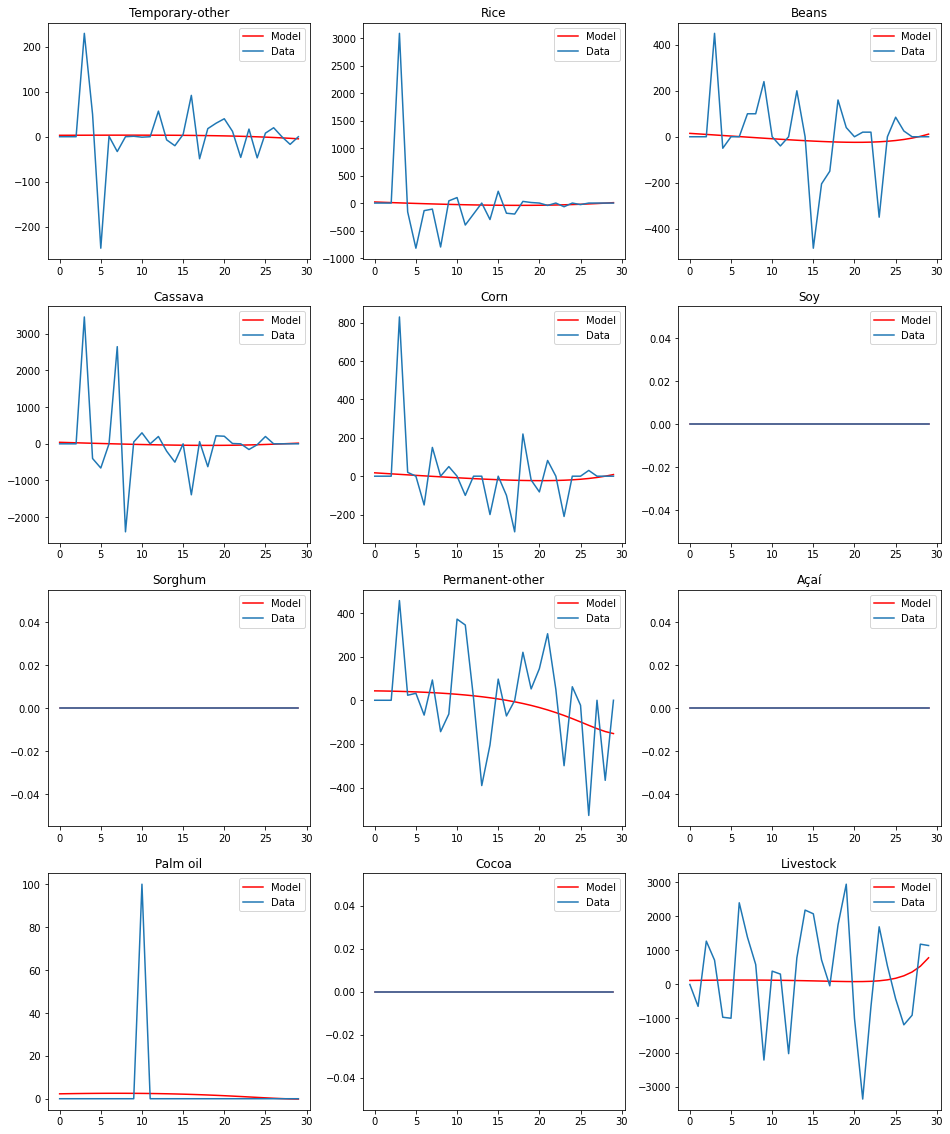

In [7]:
make_score_for_city(UNIQUE_CITY_CODES[3], show_graphs=True)

In [9]:
# pd.DataFrame([[a,b] for a, b in zip(a, UNIQUE_CITY_CODES)],columns=['WMAPE', 'city_code']).to_csv('./results/city_clustering_v2.csv')
sum(a)

1859.5637240371195